# Comparison between mouse and human gastruloids

In order to comapre gene expression profiles between mouse and human gastruloids, only reproducible genes with human-mouse orthologous are selected. This notebook contains the code required to produce heatmap showing the different gene expression profiles between the two systems. Comparisons are done twice: mouse gastruloids are compared to either ChiSB43-grown gastruloids or Chi-grown gastruloids.

In [2]:
import glob
import venn
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
import Colors

In [3]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [4]:
np.random.seed(174612)

# read Lfng tomo data

In [5]:
glob.glob('../*normfilt*')

['../mG01_E08_5dAA_lngf.normfilt.coutt.tsv.gz',
 '../mG02_F08_5dAA_lngf.normfilt.coutt.tsv.gz',
 '../mG03_B10_5dAA_lngf.normfilt.coutt.tsv.gz']

In [6]:
ndfs_L = [read_csv(f, sep = '\t', index_col=0) for f in glob.glob('../*normfilt*')]

In [7]:
for df in ndfs_L:
    df.index = ['_'.join(idx.rsplit('_')[:2]) for idx in df.index]
    df.columns = [c + '-L' for c in df.columns]

In [8]:
for df in ndfs_L:
    df = df.loc[df.index[df.sum(axis=1)>0]]

In [9]:
zdfs_L = [zscore(df) for df in ndfs_L]

In [10]:
gene_corr_L = read_csv('../results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [11]:
gene_corr_L.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_L.index]

In [12]:
gene_corr_L.head()

corr_(0, 1)  pv_(0, 1)  adj-pv_(0, 1)  corr_(0, 2)  \
ENSMUSG00000000001_Gnai3    -0.052702   0.648430       0.849729    -0.026991   
ENSMUSG00000000028_Cdc45    -0.149606   0.857471       0.900678     0.233418   
ENSMUSG00000000031_H19       0.563323   0.000000       0.000000     0.528238   
ENSMUSG00000000037_Scml2    -0.174997   0.892879       0.922340     0.080947   
ENSMUSG00000000056_Narf     -0.196799   0.918484       0.939695     0.150490   

                          pv_(0, 2)  adj-pv_(0, 2)  corr_(1, 2)  pv_(1, 2)  \
ENSMUSG00000000001_Gnai3   0.582617       0.878416    -0.065006   0.671834   
ENSMUSG00000000028_Cdc45   0.042509       0.309357    -0.092482   0.739648   
ENSMUSG00000000031_H19     0.000000       0.000000     0.553930   0.000000   
ENSMUSG00000000037_Scml2   0.279956       0.878416     0.133182   0.181936   
ENSMUSG00000000056_Narf    0.131726       0.599934     0.124855   0.197139   

                          adj-pv_(1, 2)  
ENSMUSG00000000001_Gnai3       0.885385  
ENSMUSG00000000028_Cdc45       0.885385  
ENSMUSG00000000031_H19         0.000000  
ENSMUSG00000000037_Scml2       0.692565  
ENSMUSG00000000056_Narf        0.721206

In [13]:
pvcols = [c for c in gene_corr_L.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_L = gene_corr_L.index[gene_corr_L.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [14]:
len(genelist_L), len(gene_corr_L)

(1456, 25828)

# read Human gastruloid data

In [15]:
file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/pooledAll_chichiSB45_normfilt.tsv'
ndf = read_csv(file, sep = '\t', index_col=0)

In [16]:
set(['-'.join(c.rsplit('-')[1:]) for c in ndf.columns])

{'hG01-chi', 'hG02-chi', 'hG03-sb', 'hG04-sb'}

In [17]:
ndfs_chi = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG01-chi', 'hG02-chi']]
ndfs_sb = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG03-sb', 'hG04-sb']]

In [18]:
for i in range(len(ndfs_chi)):
    ndfs_chi[i].index = ['_'.join(idx.rsplit('_')[:2]) for idx in ndfs_chi[i].index]
    print(ndfs_chi[i].shape)
    print((ndfs_chi[i].sum(axis=1)==0).sum())
    ndfs_chi[i] = ndfs_chi[i].loc[ndfs_chi[i].index[ndfs_chi[i].sum(axis=1)>0]]
    print(ndfs_chi[i].shape)
for i in range(len(ndfs_sb)):
    ndfs_sb[i].index = ['_'.join(idx.rsplit('_')[:2]) for idx in ndfs_sb[i].index]
    print(ndfs_sb[i].shape)
    print((ndfs_sb[i].sum(axis=1)==0).sum())
    ndfs_sb[i] = ndfs_sb[i].loc[ndfs_sb[i].index[ndfs_sb[i].sum(axis=1)>0]]
    print(ndfs_sb[i].shape)


(19458, 24)
2759
(16699, 24)
(19458, 22)
2916
(16542, 22)
(19458, 44)
2179
(17279, 44)
(19458, 41)
2071
(17387, 41)


In [19]:
zdfs_chi = [zscore(df) for df in ndfs_chi]
zdfs_sb = [zscore(df) for df in ndfs_sb]

In [20]:
[df.shape for df in zdfs_chi+zdfs_sb]

[(16699, 24), (16542, 22), (17279, 44), (17387, 41)]

In [21]:
file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/geneCorrelations_Chi.tsv'
gene_corr_chi = read_csv(file, sep = '\t', index_col=0)

file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/geneCorrelations_ChiSB43.tsv'
gene_corr_sb = read_csv(file, sep = '\t', index_col=0)

In [22]:
gene_corr_chi.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_chi.index]
gene_corr_sb.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_sb.index]

In [23]:
pvth = 0.005
genelist_chi = gene_corr_chi.index[gene_corr_chi['pv']<pvth]
len(genelist_chi)

1391

In [24]:
pvth = 0.001
genelist_sb = gene_corr_sb.index[gene_corr_sb['pv']<pvth]
len(genelist_sb)

1266

# rename using orthologs

In [25]:
file = '/Users/anna/Dropbox/gastruloids/data/human-mouse-orthologous.txt.gz'
ortos = read_csv(file, sep = '\t')

In [26]:
ortos['human'] = ortos.apply(lambda x: '_'.join(x[['Gene stable ID','Gene name']]), axis = 1)
ortos['mouse'] = ortos.apply(lambda x: '_'.join(x[['Mouse gene stable ID','Mouse gene name']]), axis = 1)

In [27]:
ortos = pd.DataFrame({g for g, df_g in ortos[['human','mouse']].groupby(['human','mouse'])}, columns = ['human','mouse'])
ortos.head()

human                       mouse
0    ENSG00000156564_LRFN2    ENSMUSG00000040490_Lrfn2
1   ENSG00000166145_SPINT1   ENSMUSG00000027315_Spint1
2      ENSG00000173786_CNP      ENSMUSG00000006782_Cnp
3   ENSG00000260458_KCNJ18   ENSMUSG00000042529_Kcnj12
4  ENSG00000249020_SNORA58  ENSMUSG00000064938_Mir3068

In [28]:
idxs = []
cntHuman = Counter(ortos['human'])
cntMouse = Counter(ortos['mouse'])
for idx in ortos.index:
    if cntHuman[ortos.loc[idx,'human']]==1 and cntMouse[ortos.loc[idx,'mouse']] == 1:
        idxs.append(idx)
clean_ortos = ortos.loc[idxs]

In [29]:
ortos.shape, clean_ortos.shape

((26568, 2), (16796, 2))

In [30]:
ortos_m2h = clean_ortos.set_index('mouse')
ortos_h2m = clean_ortos.set_index('human')

# gene sets to perform comparisons
Only select genes with a single ortholog

In [31]:
genelist_L_hortos = [ortos_m2h.loc[g,'human'] for g in genelist_L if g in ortos_m2h.index]
len(genelist_L_hortos), len(genelist_L)

(1260, 1456)

In [32]:
genelist_chi_hortos = [g for g in genelist_chi if g in ortos_h2m.index]
len(genelist_chi_hortos), len(genelist_chi)

(1205, 1391)

In [33]:
genelist_sb_hortos = [g for g in genelist_sb if g in ortos_h2m.index]
len(genelist_sb_hortos), len(genelist_sb)

(1095, 1266)

In [34]:
population = list(set(genelist_L_hortos+genelist_chi_hortos+genelist_sb_hortos))
population = pd.Series({p: ortos_h2m.loc[p,'mouse'].rsplit('_')[1] for p in population})
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprChiLfng/population_allRepr.txt', index = None, header = None)
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprSBLfng/population_allRepr.txt', index = None, header = None)
len(population)

2643

In [35]:
population = pd.Series({p: ortos_h2m.loc[p,'mouse'].rsplit('_')[1] for p in genelist_chi_hortos})
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprChiLfng/population_ReprChi.txt', index = None, header = None)
len(population)

1205

In [36]:
population = pd.Series({p: ortos_h2m.loc[p,'mouse'].rsplit('_')[1] for p in set(genelist_L_hortos+genelist_chi_hortos)})
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprChiLfng/population_ReprChiLfng.txt', index = None, header = None)
len(population)


2142

In [37]:
population = pd.Series({p: ortos_h2m.loc[p,'mouse'].rsplit('_')[1] for p in genelist_sb_hortos})
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprSBLfng/population_ReprSB.txt', index = None, header = None)
len(population)

1095

In [38]:
population = pd.Series({p: ortos_h2m.loc[p,'mouse'].rsplit('_')[1] for p in set(genelist_sb_hortos+genelist_L_hortos)})
pd.DataFrame(population).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprSBLfng/population_ReprSBLfng.txt', index = None, header = None)
len(population)

1965

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


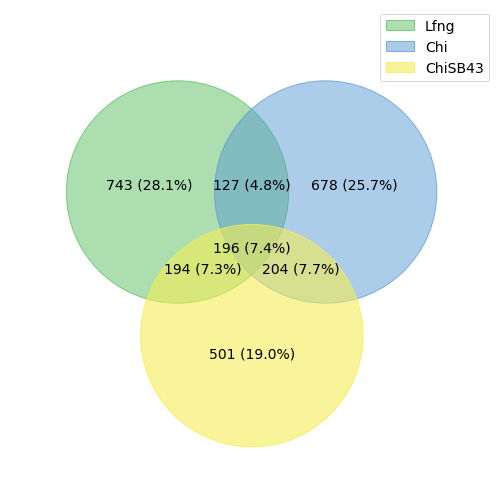

In [39]:
labels = venn.get_labels([set(genelist_L_hortos),
                          set(genelist_chi_hortos),
                          set(genelist_sb_hortos)], 
                         fill=['number','percent'])

for k in labels:
    if labels[k][0:1]=='0': 
        labels[k] = ''
        
fig, ax = venn.venn3(labels, names=['Lfng', 'Chi', 'ChiSB43'])

plt.savefig('../results/comparison_Lfng_human_gastruloids/venn_genes.pdf', bbox_inches = 'tight')
plt.show()

# clustering

In [40]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [41]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [42]:
ortos_m2h.head()

human
mouse                                              
ENSMUSG00000040490_Lrfn2      ENSG00000156564_LRFN2
ENSMUSG00000027315_Spint1    ENSG00000166145_SPINT1
ENSMUSG00000006782_Cnp          ENSG00000173786_CNP
ENSMUSG00000064938_Mir3068  ENSG00000249020_SNORA58
ENSMUSG00000032473_Cldn18    ENSG00000066405_CLDN18

In [43]:
ndfs_L_ortos = []
for df in ndfs_L: 
    idxs = [idx for idx in df.index if idx in ortos_m2h.index]
    tdf = df.loc[idxs]
    tdf.index = [ortos_m2h.loc[idx,'human'] for idx in tdf.index]
    ndfs_L_ortos.append(tdf)
    print(df.shape, tdf.shape)
    
zdfs_L_ortos = []
for df in zdfs_L: 
    idxs = [idx for idx in df.index if idx in ortos_m2h.index]
    tdf = df.loc[idxs]
    tdf.index = [ortos_m2h.loc[idx,'human'] for idx in tdf.index]
    zdfs_L_ortos.append(tdf)
    print(df.shape, tdf.shape)

(25828, 53) (14365, 53)
(25828, 47) (14365, 47)
(25828, 44) (14365, 44)
(25828, 53) (14365, 53)
(25828, 47) (14365, 47)
(25828, 44) (14365, 44)


In [44]:
mndf_L = mergeDfs(ndfs_L_ortos)
mndf_chi = mergeDfs(ndfs_chi)
mndf_sb = mergeDfs(ndfs_sb)

mndf_Lchi = mergeDfs(ndfs_L_ortos + ndfs_chi)
mndf_Lsb = mergeDfs(ndfs_L_ortos + ndfs_sb)

In [45]:
mzdf_L = mergeDfs(zdfs_L_ortos)
mzdf_chi = mergeDfs(zdfs_chi)
mzdf_sb = mergeDfs(zdfs_sb)

mzdf_Lchi = mergeDfs(zdfs_L_ortos + zdfs_chi)
mzdf_Lsb = mergeDfs(zdfs_L_ortos + zdfs_sb)

# Average gastruloids

In [46]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set(['-'.join(c.rsplit('-')[-2:]) for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == '-'.join(c.rsplit('-')[-2:])]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [47]:
xdf_L = averageGastruloid(mzdf_L, min([len(df.columns) for df in zdfs_L]))
xdf_chi = averageGastruloid(mzdf_chi, min([len(df.columns) for df in zdfs_chi]))
xdf_sb = averageGastruloid(mzdf_sb, min([len(df.columns) for df in zdfs_sb]))

In [48]:
xdf_L.to_csv('../../hGstl-tomo/av_mouseGld.tsv', sep = '\t')
xdf_chi.to_csv('../../hGstl-tomo/av_humanGld_chi.tsv', sep = '\t')
xdf_sb.to_csv('../../hGstl-tomo/av_humanGld_chiSB43.tsv', sep = '\t')


In [50]:
zdfs_L_ortos[0].to_csv('../../hGstl-tomo/mGld1_zscore.tsv', sep = '\t')
zdfs_L_ortos[1].to_csv('../../hGstl-tomo/mGld2_zscore.tsv', sep = '\t')
zdfs_L_ortos[2].to_csv('../../hGstl-tomo/mGld3_zscore.tsv', sep = '\t')

In [53]:
zdfs_chi[0].to_csv('../../hGstl-tomo/hGld1_chi_zscore.tsv', sep = '\t')
zdfs_chi[1].to_csv('../../hGstl-tomo/hGld2_chi_zscore.tsv', sep = '\t')

# Lnfg compared to Chi
First let's take only genes reproducible in Lfng and not reproducible in Chi. These need to be split in two sets: the ones found also in Chi (not reproducibly) and the oens that are not foudn in Chi

In [47]:
len(genelist_L_hortos)

1260

In [48]:
genelist_L_hortos_noreprchi = [g for g in genelist_L_hortos if g not in genelist_chi_hortos]
len(genelist_L_hortos_noreprchi)

937

In [49]:
genelist_L_hortos_noreprchi_noexprchi = []
for df in ndfs_chi:
    genelist_L_hortos_noreprchi_noexprchi += [g for g in genelist_L_hortos_noreprchi if g not in df.index]
genelist_L_hortos_noreprchi_noexprchi = np.array(list(set(genelist_L_hortos_noreprchi_noexprchi)))

In [50]:
genelist_L_hortos_noreprchi_exprchi = [g for g in genelist_L_hortos_noreprchi if g not in genelist_L_hortos_noreprchi_noexprchi]

In [51]:
len(genelist_L_hortos_noreprchi_noexprchi), len(genelist_L_hortos_noreprchi_exprchi)

(79, 858)

In [52]:
5*np.sqrt(76), 5*np.sqrt(852)

(43.58898943540674, 145.94519519326423)

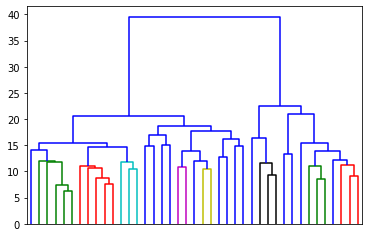

In [53]:
somhcl_L_noreprchi_noexprchi_df = comboCluster(mzdf_L, genelist_L_hortos_noreprchi_noexprchi, cth=12, gridheight=6, gridwidth=7)


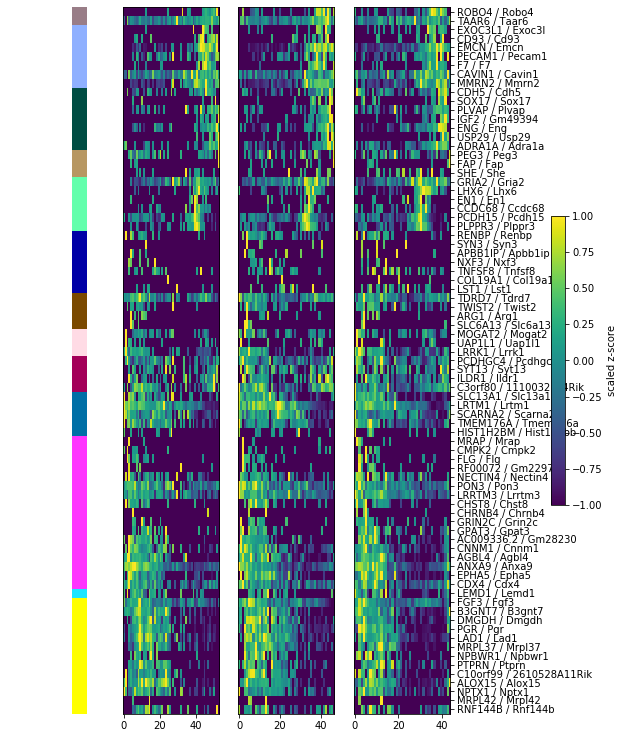

In [54]:
plt.figure(figsize=(10,13))

hcldf = somhcl_L_noreprchi_noexprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(zdfs_L_ortos)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[-1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order)])


plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_noExprChi.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_noExprChi.tsv', sep = '\t')

plt.show()

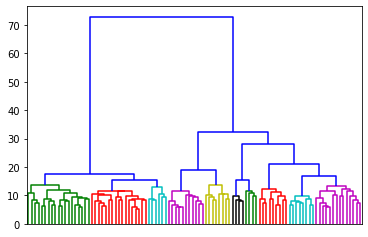

In [55]:
somhcl_L_noreprchi_exprchi_df = comboCluster(mzdf_Lchi, genelist_L_hortos_noreprchi_exprchi, cth=14)

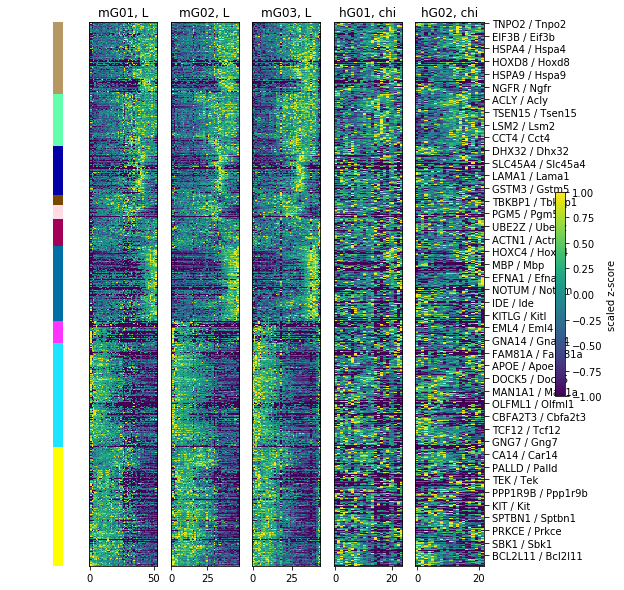

In [56]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_L_noreprchi_exprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_chi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos+zdfs_chi):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx])
plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_ExprChi.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_ExprChi.tsv', sep = '\t')

plt.show()

Now, let's take only genes reproducible in Lfng and not reproducible in Chi. These need to be split in two sets: the ones found also in Lfng (not reproducibly) and the oens that are not found in Lfng

In [57]:
len(genelist_chi), len(genelist_chi_hortos)

(1391, 1205)

In [58]:
genelist_chi_hortos_noreprL = [g for g in genelist_chi_hortos if g not in genelist_L_hortos]
len(genelist_chi_hortos_noreprL)

882

In [59]:
genelist_chi_hortos_noreprL_noexprL = []
for df in ndfs_L_ortos:
    genelist_chi_hortos_noreprL_noexprL += [g for g in genelist_chi_hortos_noreprL if g not in df.index]
genelist_chi_hortos_noreprL_noexprL = np.array(list(set(genelist_chi_hortos_noreprL_noexprL)))

genelist_chi_hortos_noreprL_exprL = np.array([g for g in genelist_chi_hortos_noreprL if g not in genelist_chi_hortos_noreprL_noexprL])

len(genelist_chi_hortos_noreprL_noexprL), len(genelist_chi_hortos_noreprL_exprL)

(40, 842)

In [60]:
5*np.sqrt(44), 5*np.sqrt(840)

(33.166247903553995, 144.9137674618944)

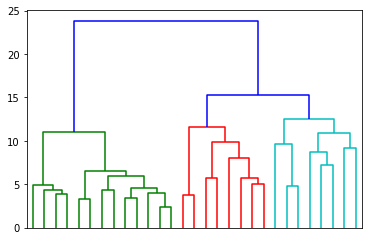

In [61]:
somhcl_chi_noReprL_noExprL_df = comboCluster(mzdf_chi, genelist_chi_hortos_noreprL_noexprL, cth=14, gridheight=7, gridwidth=7)


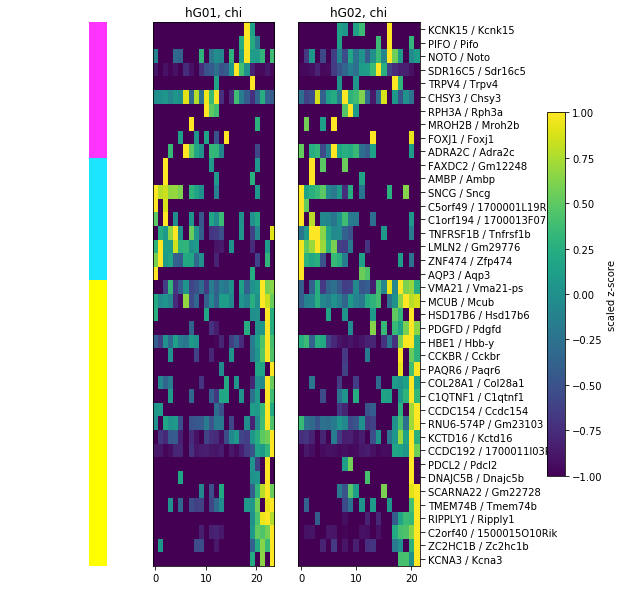

In [62]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chi_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_chi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_chi):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[-1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order)])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprLfng_noExprLfng.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprLfng_noExprLfng.tsv', sep = '\t')

plt.show()

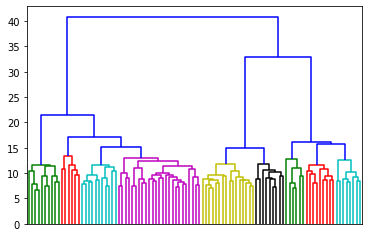

In [63]:
somhcl_chi_noReprL_noExprL_df = comboCluster(mzdf_Lchi, genelist_chi_hortos_noreprL_exprL, cth=14, gridheight=10, gridwidth=10)

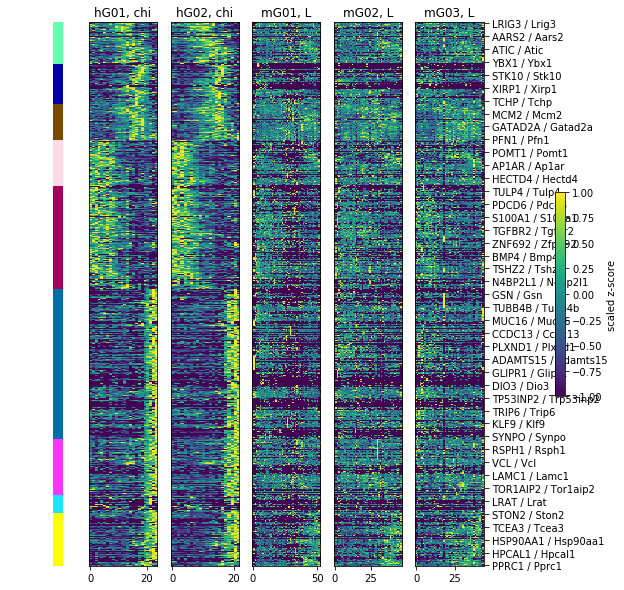

In [64]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chi_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_chi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_chi+zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprL_ExprL.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprL_ExprL.tsv', sep = '\t')

plt.show()

And now, finally, genes that are reproducible in both Lfng and Chi gastruloids.

In [65]:
genelist_chiL_hortos = [g for g in genelist_chi_hortos if g in genelist_L_hortos]
len(genelist_chiL_hortos)

323

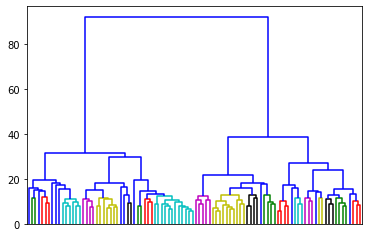

In [66]:
somhcl_chiL_df = comboCluster(mzdf_Lchi, genelist_chiL_hortos, cth=13, gridheight=10, gridwidth=10)

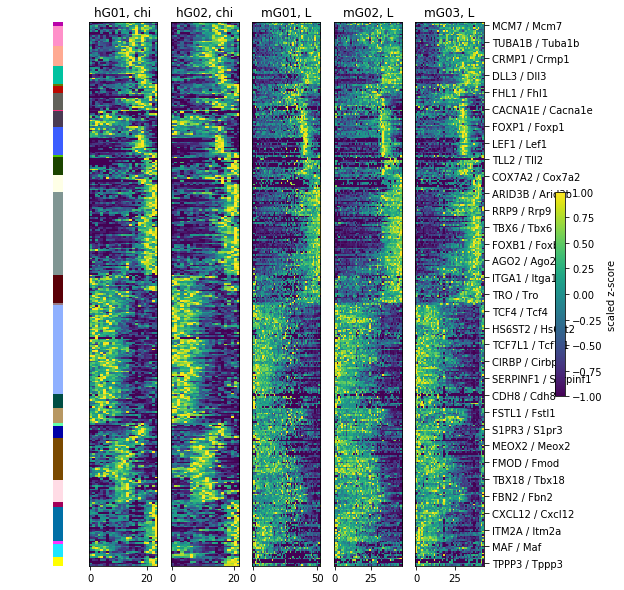

In [67]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chiL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_chi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_chi+zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng.tsv', sep = '\t')

plt.show()

In [68]:
somhcl_chiL_df['orto'] = [ortos_h2m.loc[g,'mouse'].rsplit('_')[1] for g in somhcl_chiL_df.index]
somhcl_chiL_df.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng.tsv', sep = '\t')
somhcl_chiL_df.head()

som  hcl   orto
ENSG00000166250_CLMP    79   11   Clmp
ENSG00000143870_PDIA6   33   23  Pdia6
ENSG00000179915_NRXN1   58   10  Nrxn1
ENSG00000120075_HOXB5   31   20  Hoxb5
ENSG00000167601_AXL     86   10    Axl

In [69]:
for cl in set(somhcl_chiL_df['hcl']):
    pd.DataFrame(somhcl_chiL_df[somhcl_chiL_df['hcl']==cl]['orto']).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprChiLfng/hcl'+str(cl).zfill(2) + '.tsv', index = None, header = None)

In [70]:
for cl in set(somhcl_chiL_df['hcl']):
    print(str(cl) + ' & ' + ', '.join(sorted([ortos_h2m.loc[g,'mouse'].rsplit('_')[1] for g in somhcl_chiL_df[somhcl_chiL_df['hcl']==cl].index])) + '\\\\') 

0 & Efcab1, L1cam, Pdlim1, Slit2, Tppp3\\
1 & Ece1, Fn1, Maf, Sema3d, Spock3, Stc1, Tgfbi, Vasn\\
2 & Dlc1, Megf6\\
3 & Col4a1, Cxcl12, Egflam, Epha7, Fkbp14, Flrt3, Flt4, Galnt16, Islr, Itm2a, Jund, Mmp2, Ndrg1, Pon2, Ramp2, Smad3, Sox18, Tes, Tpcn1, Wwtr1\\
4 & Fam107b, Nucb1, Pdzd2\\
5 & Col18a1, Dmd, Fbn2, Foxd1, Fst, Lrig1, Ltbp1, Meox1, Pax3, Rasl11b, Sim1, Tcf15, Uaca\\
6 & Arhgap28, Boc, Col12a1, Col1a2, Colec12, Ddit4l, Fignl2, Fmod, Foxd2, Gas1, Klhl4, Meox2, Mgat5, Nnat, Nr2f2, Nrp2, Peg10, Sdk2, Sema5a, Six1, Sparc, Tbx18, Tspan18, Zfhx2, Zfp36l1\\
7 & Copg2, Ism1, Mest, Nab2, S1pr3, Stra6, Tspan13\\
8 & Arsg, Fzd7\\
9 & Ednra, Fstl1, Irx1, Meis1, Nrg1, Pkdcc, Prrx2, Tfpi, Twist1\\
10 & Axl, Cdh8, Cntnap2, Col23a1, Mafb, Meis3, Mfap4, Nrxn1\\
11 & Adamts12, Arhgap29, Bmf, Cblb, Cd248, Cdh11, Cdon, Cers6, Cirbp, Clmp, Col2a1, Cttnbp2, Dlk1, Emilin1, Esam, Flrt2, Foxo1, Fzd4, Glcci1, Hs6st2, Igfbp5, Itga9, Kdr, Klhl24, Lgr4, Lifr, Marcks, Mecom, Meis2, Mrc2, Nr2f1, Nrep, Nrip

In [71]:
# make average gastruloid for each ocnditions from the different replicates

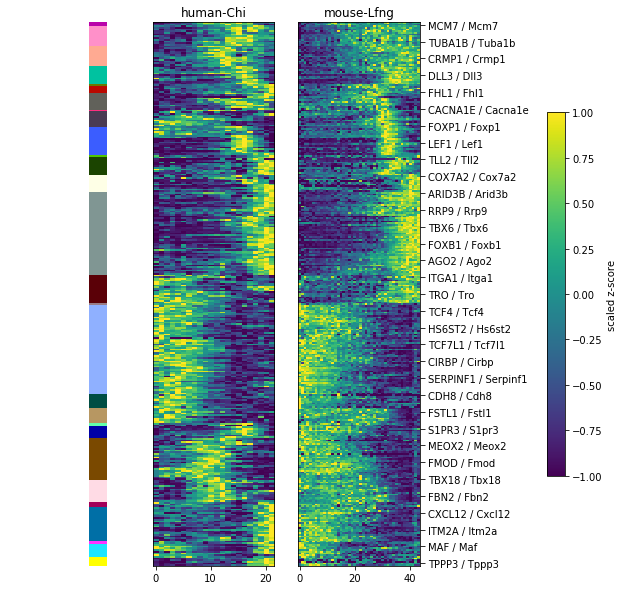

In [72]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chiL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = 2+2
plt.subplot(1,Npl,1, frameon = False)
titles = ['human-Chi','mouse-Lfng']

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate([xdf_chi, xdf_L]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1].astype(float)), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng_averages.pdf', bbox_inches = 'tight')
hcldf.to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng_averages.tsv', sep = '\t')

plt.show()

# Lnfg compared to ChiSB43
First let's take only genes reproducible in Lfng and not reproducible in ChiSB43. These need to be split in two sets: the ones found also in ChiSB43 (not reproducibly) and the ones that are not found in ChiSB43

In [73]:
len(genelist_L), len(genelist_L_hortos)

(1456, 1260)

In [74]:
genelist_L_hortos_noreprSB = [g for g in genelist_L_hortos if g not in genelist_sb_hortos]
len(genelist_L_hortos_noreprSB)

870

In [75]:
genelist_L_hortos_noreprSB_noexprSB = []
for df in ndfs_sb:
    genelist_L_hortos_noreprSB_noexprSB += [g for g in genelist_L_hortos_noreprSB if g not in df.index]
genelist_L_hortos_noreprSB_noexprSB = np.array(list(set(genelist_L_hortos_noreprSB_noexprSB)))

genelist_L_hortos_noreprSB_exprSB = [g for g in genelist_L_hortos_noreprSB if g not in genelist_L_hortos_noreprSB_noexprSB]

len(genelist_L_hortos_noreprSB_noexprSB), len(genelist_L_hortos_noreprSB_exprSB)

(67, 803)

In [76]:
5*np.sqrt(64), 5*np.sqrt(711)

(40.0, 133.32291625973383)

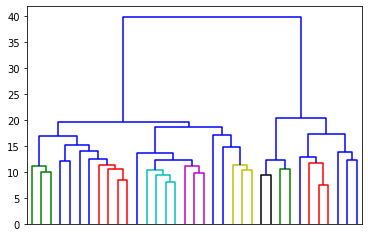

In [77]:
somhcl_L_noreprsb_noexprsb_df = comboCluster(mzdf_L, genelist_L_hortos_noreprSB_noexprSB, cth=12, gridheight=8, gridwidth=5)


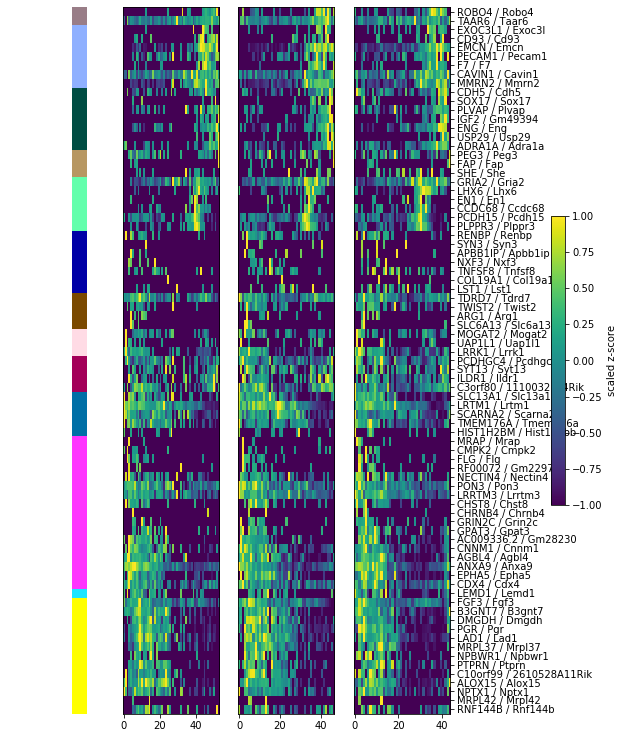

In [78]:
plt.figure(figsize=(10,13))

hcldf = somhcl_L_noreprchi_noexprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(zdfs_L_ortos)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[-1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order)])


plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprSB_noExprSB.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprSB_noExprSB.tsv', sep = '\t')

plt.show()


In [79]:
pwd


'/Users/anna/Dropbox/gastruloids/data/Lnfg-mGst-tomo/notebooks'

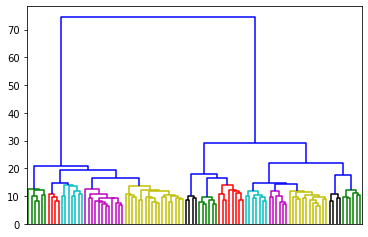

In [80]:
somhcl_L_noreprSB_exprSB_df = comboCluster(mzdf_Lsb, genelist_L_hortos_noreprSB_exprSB, cth=14)

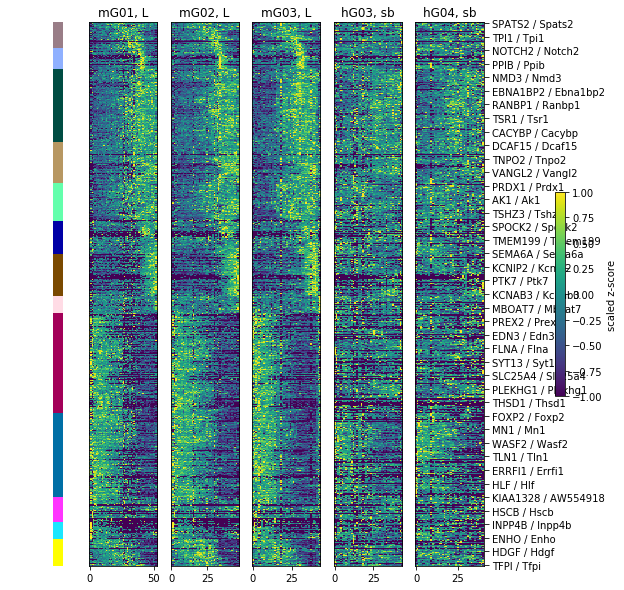

In [81]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_L_noreprSB_exprSB_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_sb)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos+zdfs_sb):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprSB_ExprSB.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprSB_ExprSB.tsv', sep = '\t')

plt.show()

Now, reproducible in ChiSB43 but not in Lfng

In [82]:
len(genelist_sb), len(genelist_sb_hortos)


(1266, 1095)

In [83]:
genelist_sb_hortos_noreprL = [g for g in genelist_sb_hortos if g not in genelist_L_hortos]
len(genelist_sb_hortos_noreprL)

705

In [84]:
genelist_sb_hortos_noreprL_noexprL = []
for df in ndfs_L_ortos:
    genelist_sb_hortos_noreprL_noexprL += [g for g in genelist_sb_hortos_noreprL if g not in df.index]
genelist_sb_hortos_noreprL_noexprL = np.array(list(set(genelist_sb_hortos_noreprL_noexprL)))

genelist_sb_hortos_noreprL_exprL = np.array([g for g in genelist_sb_hortos_noreprL if g not in genelist_sb_hortos_noreprL_noexprL])

len(genelist_sb_hortos_noreprL_noexprL), len(genelist_sb_hortos_noreprL_exprL)

(26, 679)

In [85]:
5*np.sqrt(39), 5*np.sqrt(1121)

(31.22498999199199, 167.40669042783207)

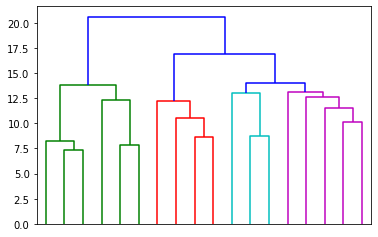

In [86]:
somhcl_sb_noReprL_noExprL_df = comboCluster(mzdf_sb, genelist_sb_hortos_noreprL_noexprL, cth=14, gridheight=6, gridwidth=5)


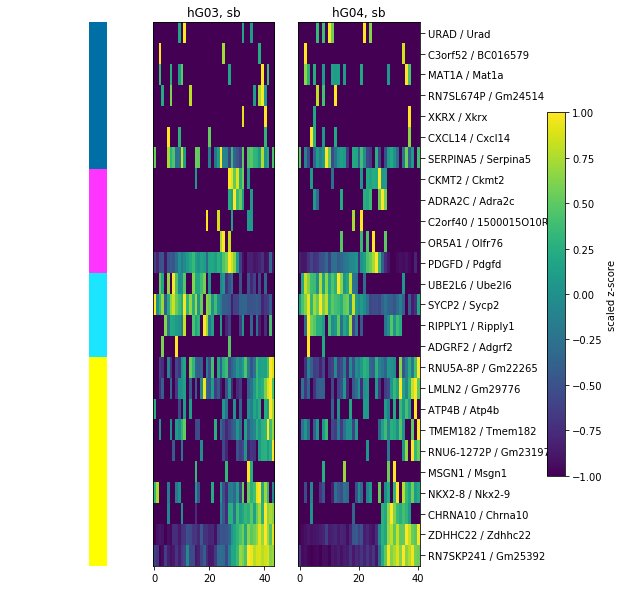

In [87]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_sb_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_sb)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_sb):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[-1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order)])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSB_noReprLfng_noExprLfng.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSB_noReprLfng_noExprLfng.tsv', sep = '\t')

plt.show()

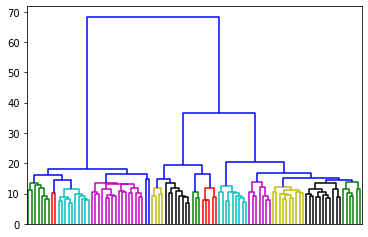

In [88]:
somhcl_sb_noReprL_ExprL_df = comboCluster(mzdf_Lsb, genelist_sb_hortos_noreprL_exprL, cth=14, gridheight=10, gridwidth=10)


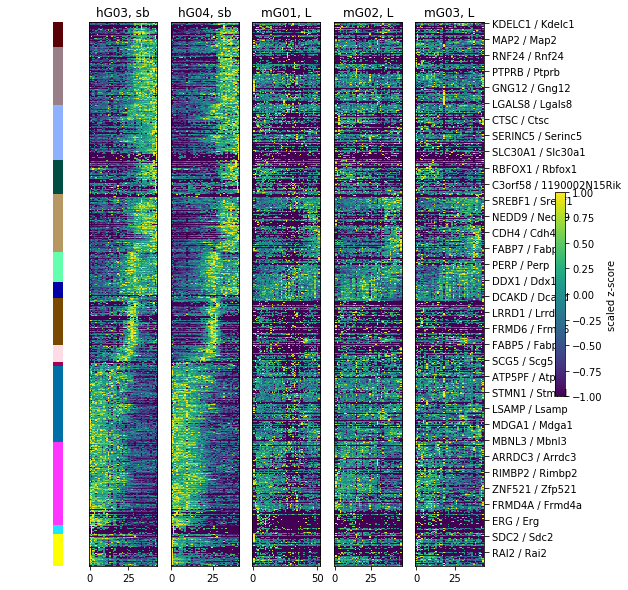

In [89]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_sb_noReprL_ExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_sb)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_sb+zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,20)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSB_noReprL_ExprL.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSB_noReprL_ExprL.tsv', sep = '\t')

plt.show()

And now, finally, genes that are reproducible in both Lfng and ChiSB43 gastruloids.


In [90]:
genelist_sbL_hortos = [g for g in genelist_sb_hortos if g in genelist_L_hortos]
len(genelist_sbL_hortos)

390

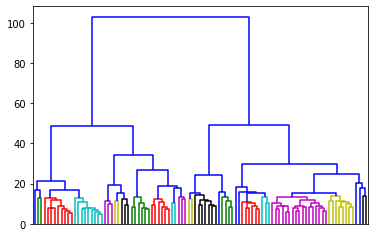

In [91]:
somhcl_sbL_df = comboCluster(mzdf_Lsb, genelist_sbL_hortos, cth=15, gridheight=10, gridwidth=10)

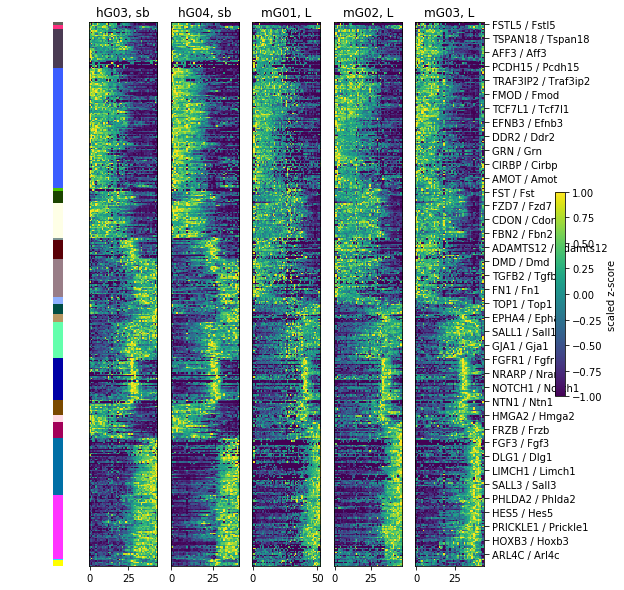

In [92]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_sbL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(ndfs_L + ndfs_sb)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_sb+zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSBLfng.pdf', bbox_inches = 'tight')
hcldf.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSBLfng.tsv', sep = '\t')

plt.show()



In [93]:
somhcl_sbL_df['orto'] = [ortos_h2m.loc[g,'mouse'].rsplit('_')[1] for g in somhcl_sbL_df.index]
somhcl_sbL_df.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSBLfng.tsv', sep = '\t')
somhcl_sbL_df.head()

som  hcl    orto
ENSG00000166250_CLMP     65   18    Clmp
ENSG00000167601_AXL      68   15     Axl
ENSG00000145242_EPHA5    41    3   Epha5
ENSG00000146278_PNRC1    98   18   Pnrc1
ENSG00000171004_HS6ST2   59   16  Hs6st2

In [94]:
for cl in set(somhcl_sbL_df['hcl']):
    pd.DataFrame(somhcl_sbL_df[somhcl_sbL_df['hcl']==cl]['orto']).to_csv('../results/comparison_Lfng_human_gastruloids/GOterms_ReprSBLfng/hcl'+str(cl).zfill(2) + '.tsv', index = None, header = None)

In [95]:
for cl in set(somhcl_sbL_df['hcl']):
    print(str(cl) + ' & ' + ', '.join(sorted([ortos_h2m.loc[g,'mouse'].rsplit('_')[1] for g in somhcl_sbL_df[somhcl_sbL_df['hcl']==cl].index])) + '\\\\') 


0 & Aplnr, Nav2, Rbp1, Sema4d\\
1 & Zic3\\
2 & Acot7, Acta2, Alpl, Arhgap24, Arl4c, Axin2, Ccnd1, Cdh6, Cdx1, Celsr1, Cpne2, Dhcr24, Dpysl5, Dusp6, Enc1, Etv4, Etv5, Fam84b, Foxb1, Fzd10, Gbx2, Hes5, Hes7, Hoxa9, Hoxb1, Hoxb2, Hoxb3, Hoxb4, Hoxc9, Hoxd9, Id1, Mllt3, Phlda2, Pim1, Pou3f2, Prickle1, Rprm, Sema3a, Slc2a1, Sox13, Sox2, Sox3, Spry2, Tbx6, Uchl1, Wnt5a\\
3 & Cdx2, Chic1, Crb2, Cxxc5, Dlg1, Eogt, Epha5, Evx1, Fam222a, Fgf15, Fgf17, Fgf3, Fgf8, Greb1, Hoxa10, Hoxa3, Hoxc10, Hoxc4, Hoxc5, Hoxc6, Hoxc8, Il17rd, Itgb5, Jarid2, Limch1, Msx1, Nkx1-2, Nrxn2, Oat, Pdpn, Ptpn14, Rarg, Sall3, Sp5, Sp8, Spry4, T, Trim2, Unc5b, Wnt3a, Wnt5b\\
4 & Alcam, Arid3b, Ccnd2, Ddit4, Frzb, Hes1, Ncam1, Ngfr, Rspo3, Sulf1, Trim9\\
5 & Eda, Foxp1, Nr6a1, Sox6, Vldlr\\
6 & Aldh1a2, Dact1, Epb41l3, Fkbp4, Hmga2, Myocd, Ntn1, Pdlim5, Rin2, Tpm1, Ybx3\\
7 & Adgrl2, Cxcr4, Dll1, Dll3, Efnb2, Ephb1, Fgf18, Fgfr1, Foxc2, Foxl2, Gadd45g, Greb1l, Jun, Lama1, Laptm4b, Lef1, Lfng, Mesp2, Notch1, Nrarp, Pcdh19

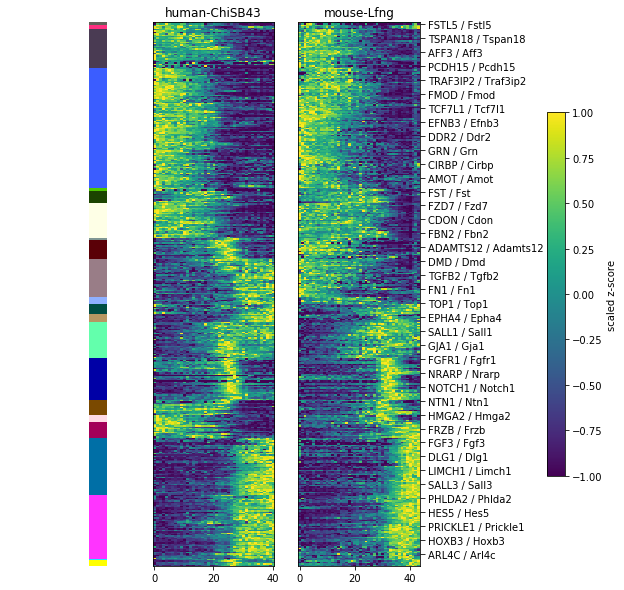

In [96]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_sbL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = 2+2
titles = ['human-ChiSB43','mouse-Lfng']

plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate([xdf_sb, xdf_L]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1].astype(float)), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSBLfng_averages.pdf', bbox_inches = 'tight')
hcldf.to_csv('../results/comparison_Lfng_human_gastruloids/heatmap_ReprSBLfng_averages.tsv', sep = '\t')

plt.show()

# Now some cherry-picked genes

## cherry-picked genes

In [97]:
# Alfonso's assigment
germlayer_genes = pd.read_excel('../../hGstl-tomo/gene_lineages_v2.xls', sheet_name='heatmap_germlayers_v2')
f_germlayer_genes = germlayer_genes.loc[[idx for idx in germlayer_genes.index if germlayer_genes.loc[idx, 'Alfonsos assigment'] in ['Endoderm','Mesoderm','Ectoderm']]]
f_germlayer_genes.head()


Alfonsos assigment                  gene name Naomis assigment alternative1  \
0           Ectoderm  ENSG00000100146_SOX10__22         Endoderm          NaN   
1           Mesoderm   ENSG00000138136_LBX1__10         Endoderm          NaN   
2           Endoderm  ENSG00000275410_HNF1B__17         Endoderm          NaN   
3           Endoderm   ENSG00000273706_LHX1__17         Endoderm          NaN   
4           Endoderm   ENSG00000189143_CLDN4__7         Endoderm          NaN   

  alternative2 alternative3  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN

In [98]:
f_germlayer_genes['gene name'] = [f_germlayer_genes.loc[idx,'gene name'].rsplit('__')[0] for idx in f_germlayer_genes.index]
f_germlayer_genes.head()


Alfonsos assigment              gene name Naomis assigment alternative1  \
0           Ectoderm  ENSG00000100146_SOX10         Endoderm          NaN   
1           Mesoderm   ENSG00000138136_LBX1         Endoderm          NaN   
2           Endoderm  ENSG00000275410_HNF1B         Endoderm          NaN   
3           Endoderm   ENSG00000273706_LHX1         Endoderm          NaN   
4           Endoderm  ENSG00000189143_CLDN4         Endoderm          NaN   

  alternative2 alternative3  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN

In [99]:
mzdf_all = mergeDfs([mzdf_L]+[mzdf_chi]+[mzdf_sb])

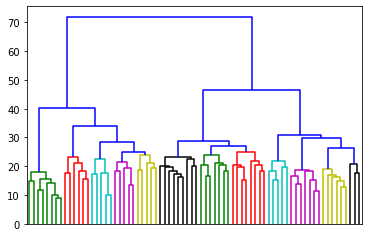

In [100]:
hcl_germlayer = linkage(mzdf_all.loc[f_germlayer_genes['gene name']], method='ward', metric='euclidean')
dg_germlayer = dendrogram(hcl_germlayer, no_labels=True, color_threshold = 25) # 5
plt.show()


/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


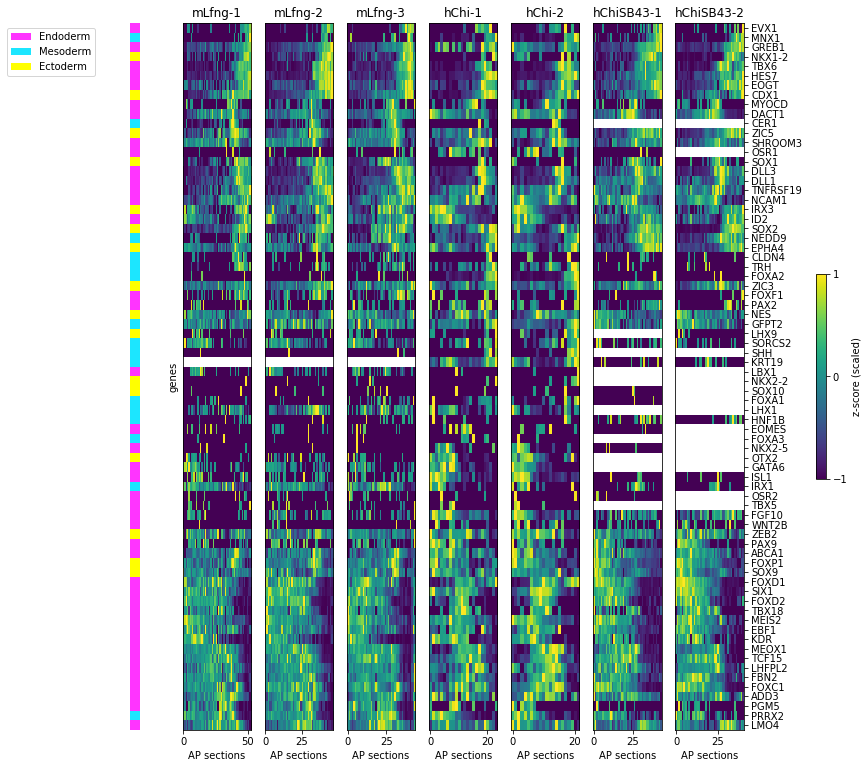

In [101]:
hcl_germlayer = getClusterByColor(dg_germlayer, list(f_germlayer_genes['gene name']))

hcl_germlayer = pd.Series({g: hcl  for hcl in hcl_germlayer for g in hcl_germlayer[hcl]})

go = hcl_germlayer.sort_values().index
N = len(zdfs_L_ortos) + len(zdfs_chi) + len(zdfs_sb) + 2

plt.figure(figsize=(13,13))
plt.subplot(1,N,1, frameon = False)
d = {'Ectoderm': 0, 'Endoderm': 1, 'Mesoderm': 2}
cnt = Counter()
y0 = 0; z0 = 0
for g in go[::-1]:
    y = 1.0/len(go)
    c = f_germlayer_genes.set_index('gene name').loc[g, 'Alfonsos assigment']
    cnt.update([c])
    if cnt[c] == 1:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]])
    else:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]], label='_nolegend_')
    y0 += y 
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)
plt.legend(['Endoderm','Mesoderm','Ectoderm'], loc = 1, bbox_to_anchor = (0,1))

titles = ['mLfng-1','mLfng-2','mLfng-3','hChi-1', 'hChi-2', 'hChiSB43-1', 'hChiSB43-2']
for i, df in enumerate(zdfs_L_ortos+zdfs_chi+zdfs_sb):
    plt.subplot(1,N,i+2)
    plt.imshow(scalezscore(df.loc[go]), aspect = 'auto')
    if i == 0:
        plt.ylabel('genes'); 
    plt.xlabel('AP sections')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
plt.yticks(range(len(go)), [x.rsplit('_')[1]  for i, x in enumerate(go)])
plt.xlabel('AP sections')

plt.subplot(1,N,N, frameon= False)
plt.colorbar(label = 'z-score (scaled)', ticks = [-1,0,1], shrink = 0.5)
plt.xticks([]); plt.yticks([])

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_germLayers.pdf', bbox_inches ='tight')

plt.show()

In [102]:
#col = 'Lineage'
col = 'Alfonsos assigment'

hcl_endo = linkage(mzdf_all.loc[f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']], method='ward', metric='euclidean')
hcl_ecto = linkage(mzdf_all.loc[f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']], method='ward', metric='euclidean')
hcl_meso = linkage(mzdf_all.loc[f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']], method='ward', metric='euclidean')

dg_endo = dendrogram(hcl_endo, no_labels=True, color_threshold = 7, no_plot=True)
dg_ecto = dendrogram(hcl_ecto, no_labels=True, color_threshold = 7, no_plot=True)
dg_meso = dendrogram(hcl_meso, no_labels=True, color_threshold = 7, no_plot=True)

hcl_endo = getClusterByColor(dg_endo, list(f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']))
hcl_ecto = getClusterByColor(dg_ecto, list(f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']))
hcl_meso = getClusterByColor(dg_meso, list(f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']))

hcl_endo = pd.Series({g: hcl  for hcl in hcl_endo for g in hcl_endo[hcl]})
hcl_ecto = pd.Series({g: hcl  for hcl in hcl_ecto for g in hcl_ecto[hcl]})
hcl_meso = pd.Series({g: hcl  for hcl in hcl_meso for g in hcl_meso[hcl]})

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


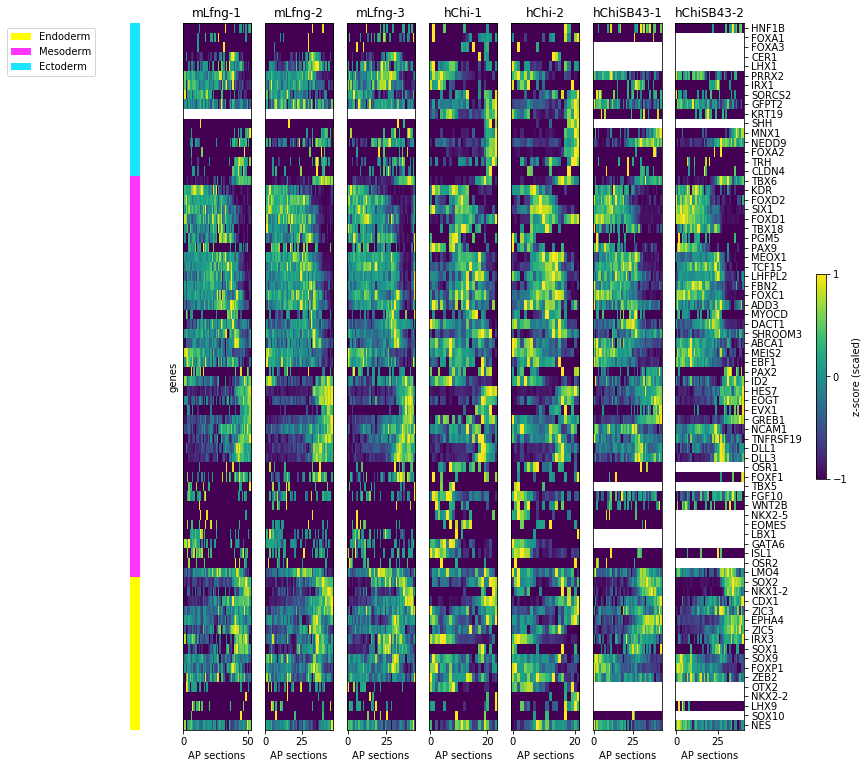

In [103]:
f_germlayer_genes.set_index('gene name').loc[g,col]

go = list(hcl_endo.sort_values().index)[::-1] + list(hcl_meso.sort_values().index) + list(hcl_ecto.sort_values().index)
N = len(zdfs_L_ortos) + len(zdfs_chi) + len(zdfs_sb) + 2

plt.figure(figsize=(13,13))
plt.subplot(1,N,1, frameon = False)
d = {'Ectoderm': 0, 'Endoderm': 1, 'Mesoderm': 2}
cnt = Counter()
y0 = 0; z0 = 0
for g in go[::-1]:
    y = 1.0/len(go)
    c = f_germlayer_genes.set_index('gene name').loc[g, col]
    cnt.update([c])
    if cnt[c] == 1:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]])
    else:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]], label='_nolegend_')
    y0 += y 
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)
plt.legend(['Endoderm','Mesoderm','Ectoderm'], loc = 1, bbox_to_anchor = (0,1))

titles = ['mLfng-1','mLfng-2','mLfng-3','hChi-1', 'hChi-2', 'hChiSB43-1', 'hChiSB43-2']
for i, df in enumerate(zdfs_L_ortos+zdfs_chi+zdfs_sb):
    plt.subplot(1,N,i+2)
    plt.imshow(scalezscore(df.loc[go]), aspect = 'auto')
    if i == 0:
        plt.ylabel('genes'); 
    plt.xlabel('AP sections')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
plt.yticks(range(len(go)), [x.rsplit('_')[1]  for i, x in enumerate(go)])
plt.xlabel('AP sections')

plt.subplot(1,N,N, frameon= False)
plt.colorbar(label = 'z-score (scaled)', ticks = [-1,0,1], shrink = 0.5)
plt.xticks([]); plt.yticks([])

plt.savefig('../results/comparison_Lfng_human_gastruloids/heatmap_LfngChiChiSB43_germLayers_sorted.pdf', bbox_inches ='tight')
plt.show()